In [136]:
# import necessary libraries
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
import pytz
import neurokit2 as nk

# ⭐⭐⭐ replace with your actual CSV file path
CSV_PATH = Path("/Users/jianingyu/Downloads/Design_Analytics/data_analysis_final/csv_data/1210AWU-G4/data_analysis_final_raw.csv")

df = pd.read_csv(CSV_PATH, parse_dates=["timestamp"])

# ==== 基本配置（你必须有这一段） ====
FS = 5                   # Empatica EDA 采样率 5 Hz
EDA_COL = "eda_uS"       # 你的 CSV 里 EDA 所在的列名
TIME_COL = "timestamp"   # 时间戳列名
ACC_COLS = ["acc_x_g", "acc_y_g", "acc_z_g"]
LOCAL_TZ = "America/New_York"

df.head()


,timestamp,acc_x_g,acc_y_g,acc_z_g,eda_uS,temperature_c,bvp
0,2025-12-10 17:22:25.789722-05:00,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-12-10 17:22:25.794757-05:00,NaN,NaN,NaN,NaN,NaN,0.000000
2,2025-12-10 17:22:25.805347-05:00,0.18300,-0.323544,0.935496,NaN,NaN,NaN
3,2025-12-10 17:22:25.810382-05:00,NaN,NaN,NaN,NaN,NaN,0.000004
4,2025-12-10 17:22:25.820971-05:00,0.19032,-0.330864,0.929152,NaN,NaN,NaN


## 第一部分：数据清理与可视化
### 包括：
#### 1. EDA特征提取（neurokit2)
#### 2. normalization
#### 3. variability
#### 4. 数据可视化(html+png)



In [137]:
# ===== 1. 确保 timestamp 是 tz-aware，并转成本地时区 =====
# 统一先当成 UTC，再转 America/New_York

# 1) 把字符串 timestamp 解析成 datetime（会自动识别 "-05:00"）
df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")

# 2) 建立本地时间列 timestamp_local
#    如果已经是 tz-aware，就 tz_convert；否则就 tz_localize
if pd.api.types.is_datetime64tz_dtype(df[TIME_COL].dtype):
    df["timestamp_local"] = df[TIME_COL].dt.tz_convert(LOCAL_TZ)
else:
    df["timestamp_local"] = df[TIME_COL].dt.tz_localize(LOCAL_TZ)

# ===== ⭐⭐⭐ 2. 在这里选择想看的时间段 =====

start_time = pd.Timestamp("2025-12-10 17:38:00", tz=LOCAL_TZ)
end_time = pd.Timestamp("2025-12-10 18:18:00", tz=LOCAL_TZ)


# ===== 3. 先按时间段截取原始 5Hz 数据 =====

# df_slice = (
#     df.set_index("timestamp_local")
#       .sort_index()
#       .loc[start_time:end_time]
#       .reset_index()
# )

mask = (df["timestamp_local"] >= start_time) & (df["timestamp_local"] <= end_time)
df_slice = df.loc[mask].copy().reset_index(drop=True)

print(f"Raw slice points: {len(df_slice)}")

# ===== 4.  Step 1: EDA preprocessing（NeuroKit2） =====

# 取出 EDA 列，并插值补 NaN
eda_raw = pd.to_numeric(df_slice["eda_uS"], errors="coerce")
eda_interp = eda_raw.interpolate(limit_direction="both")

# NeuroKit2 预处理 + SCL / SCR 分解
eda_signals, eda_info = nk.eda_process(eda_interp, sampling_rate=FS)

# 把 EDA_Clean / EDA_Tonic / EDA_Phasic 合并回 df_slice
df_slice_proc = pd.concat(
    [df_slice.reset_index(),   # 带 timestamp_local
     eda_signals[["EDA_Clean", "EDA_Tonic", "EDA_Phasic"]].reset_index(drop=True)],
    axis=1
)



# ===== 5. 为了画图更干净：把所有信号按 1 秒下采样 =====
df_downsampled = (
    df_slice_proc
      .set_index("timestamp_local")
      .resample("200ms")
      .mean()
      .dropna(how="all")
      .reset_index()
)


print(f"Downsampled points: {len(df_downsampled)}")
df_downsampled.head()


/var/folders/22/0vpdqgyx5q717n66h48gjd500000gn/T/ipykernel_49485/1144583484.py:9: DeprecationWarning:

is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.

/Users/jianingyu/Downloads/MAS-S63_project/.venv/lib/python3.11/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning:

EDA signal is sampled at very low frequency. Skipping filtering.



Raw slice points: 320438
Downsampled points: 11936


,timestamp_local,index,timestamp,acc_x_g,acc_y_g,acc_z_g,eda_uS,temperature_c,bvp,EDA_Clean,EDA_Tonic,EDA_Phasic
0,2025-12-10 17:38:00-05:00,13.5,2025-12-10 17:38:00.097920256-05:00,-0.014490,0.451550,0.903288,0.073582,31.507812,0.010945,0.073852,0.073987,-0.000135
1,2025-12-10 17:38:00.200000-05:00,40.5,2025-12-10 17:38:00.300739584-05:00,-0.012238,0.449260,0.902087,0.074893,NaN,0.017345,0.074594,0.074233,0.000361
2,2025-12-10 17:38:00.400000-05:00,67.5,2025-12-10 17:38:00.500809984-05:00,-0.014640,0.452451,0.900698,0.073087,NaN,-0.024888,0.073529,0.073736,-0.000207
3,2025-12-10 17:38:00.600000-05:00,94.0,2025-12-10 17:38:00.698996992-05:00,-0.011265,0.449082,0.903979,NaN,NaN,-0.003920,0.073187,0.073190,-0.000002
4,2025-12-10 17:38:00.800000-05:00,120.0,2025-12-10 17:38:00.894729216-05:00,-0.011299,0.449260,0.902725,0.073262,NaN,0.024956,0.072885,0.072778,0.000107


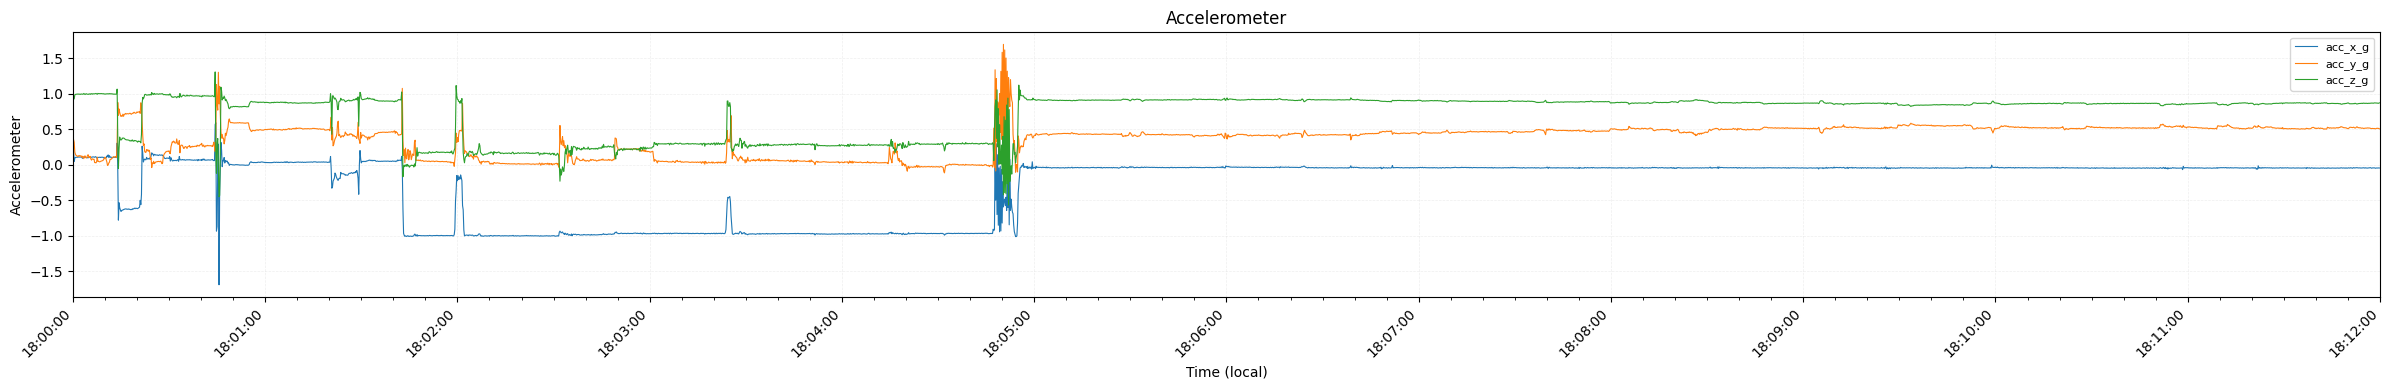

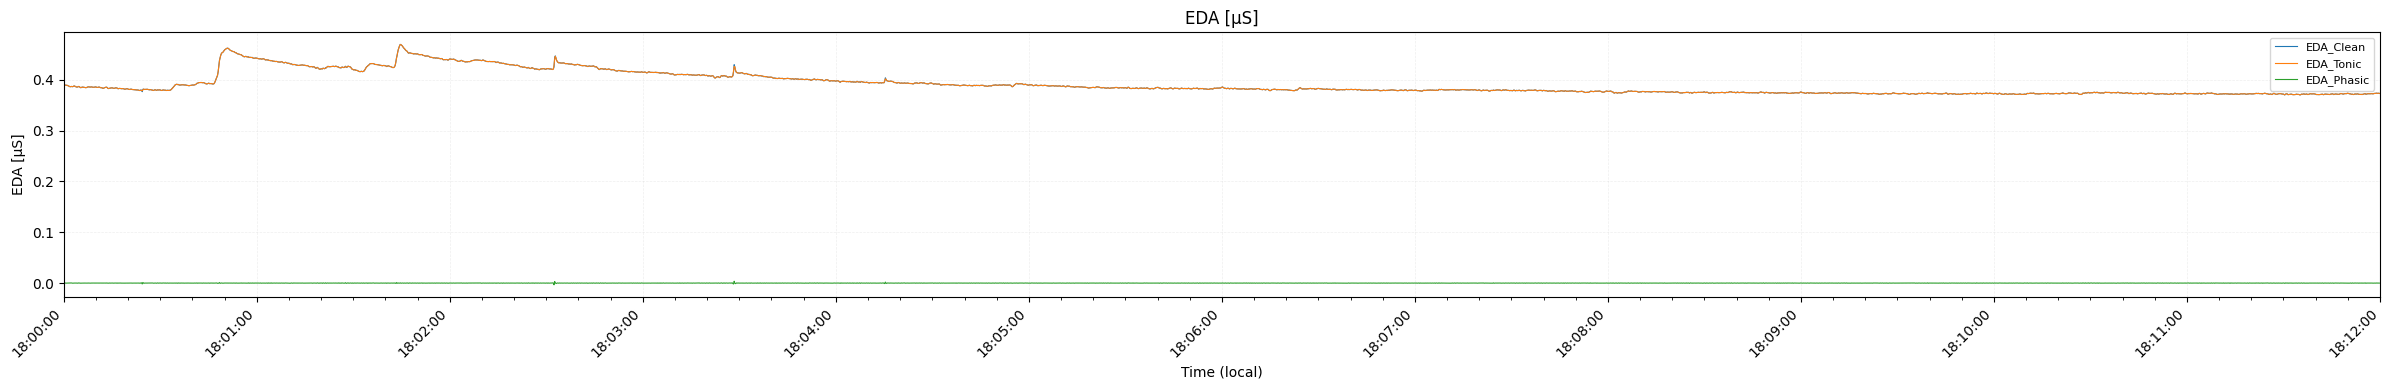

In [88]:
# ===== 画图 (optional) =====

# 只保留 Accelerometer + EDA（3 条：Clean / SCL / SCR）
signals = [
    ("Accelerometer", ["acc_x_g", "acc_y_g", "acc_z_g"]),
    ("EDA [µS]", ["EDA_Clean", "EDA_Tonic", "EDA_Phasic"]),
]

# 对应 y 轴固定范围（可以再微调）
# fixed_ranges = {
#     "Accelerometer": (-2.0, 2.0),
#     "EDA [µS]": (0.0, 0.1),   # 视你的数据幅度可以改，比如 (0.02, 0.06)
# }


# 时间轴设置
eastern = pytz.timezone("US/Eastern")
major_locator = mdates.MinuteLocator(interval=1, tz=eastern)
major_formatter = mdates.DateFormatter("%H:%M:%S", tz=eastern)
minor_locator = mdates.SecondLocator(bysecond=range(0, 60, 10), tz=eastern)

# 动态宽度（你原来的写法，想放大可以调最后的系数）
duration_seconds = max((end_time - start_time) / timedelta(seconds=1), 1)
duration_minutes = duration_seconds / 60
# 原本是 *1，很窄；这里我帮你稍微放大一点点，如果不想改可以改回去
width = max(8, duration_minutes * 2)   # 每分钟 2 英寸，至少 8 英寸宽

# === ⭐ 主循环：每个 signal 单独生成一个 figure ===
for title, cols in signals:
    fig, ax = plt.subplots(figsize=(width, 4))  # 每张图高度 4
    
    for col in cols:
        if col in df_downsampled:
            ax.plot(
                df_downsampled["timestamp_local"],
                df_downsampled[col],
                label=col,
                linewidth=0.8,
            )

    # y 轴范围
    # ymin, ymax = fixed_ranges[title]
    # padding = 0.05 * (ymax - ymin if ymax != ymin else max(abs(ymax), 1))
    # ax.set_ylim(ymin - padding, ymax + padding)

    # 自动计算当前图的 y 范围（根据所有列）
    y_values = []

    for col in cols:
        if col in df_downsampled:
            y_values.extend(df_downsampled[col].dropna().tolist())

    if len(y_values) > 0:
        ymin = min(y_values)
        ymax = max(y_values)

        # 加 padding，让图不要贴边
        padding = 0.05 * (ymax - ymin if ymax != ymin else max(abs(ymax), 1))
        ax.set_ylim(ymin - padding, ymax + padding)


    # y 轴标签
    ax.set_ylabel(title)

    # 网格
    ax.grid(alpha=0.2, linestyle="--", linewidth=0.5)

    # legend（如果有多个数据列）
    if len(cols) > 1:
        ax.legend(fontsize=8)

    ax.tick_params(labelsize=10)

    # 时间轴格式
    ax.set_xlim(start_time, end_time)
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_major_formatter(major_formatter)
    ax.xaxis.set_minor_locator(minor_locator)

    # x 轴标签
    ax.set_xlabel("Time (local)")
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

    plt.title(title)
    plt.tight_layout()
    plt.show()


In [138]:
# ==== EDA z-score normalization & 导出 CSV ====

# 想要做 z-score 的列（可以按需增减）
eda_cols_to_norm = ["EDA_Clean", "EDA_Tonic", "EDA_Phasic"]

for col in eda_cols_to_norm:
    if col in df_downsampled.columns:
        mean_val = df_downsampled[col].mean()
        std_val  = df_downsampled[col].std()

        # 避免 std = 0 导致除零
        if std_val == 0 or pd.isna(std_val):
            print(f"[WARN] Column {col} has zero/NaN std, skip normalization.")
            continue

        z_col = col + "_z"  # 比如 EDA_Tonic_z
        df_downsampled[z_col] = (df_downsampled[col] - mean_val) / std_val
    else:
        print(f"[WARN] Column {col} not found in processed, skip.")

# 生成输出文件名：原文件名 + _eda_normalized.csv
output_csv_path = CSV_PATH.with_name(CSV_PATH.stem + "_eda_normalized.csv")

# 导出完整 processed（包含原始列 + z-score 列）
df_downsampled.to_csv(output_csv_path, index=False)

print(f"✅ EDA normalized CSV saved to: {output_csv_path}")
df_downsampled.head()


✅ EDA normalized CSV saved to: /Users/jianingyu/Downloads/Design_Analytics/data_analysis_final/csv_data/1210AWU-G4/data_analysis_final_raw_eda_normalized.csv


,timestamp_local,index,timestamp,acc_x_g,acc_y_g,acc_z_g,eda_uS,temperature_c,bvp,EDA_Clean,EDA_Tonic,EDA_Phasic,EDA_Clean_z,EDA_Tonic_z,EDA_Phasic_z
0,2025-12-10 17:38:00-05:00,13.5,2025-12-10 17:38:00.097920256-05:00,-0.014490,0.451550,0.903288,0.073582,31.507812,0.010945,0.073852,0.073987,-0.000135,-0.960153,-0.948258,-0.300236
1,2025-12-10 17:38:00.200000-05:00,40.5,2025-12-10 17:38:00.300739584-05:00,-0.012238,0.449260,0.902087,0.074893,NaN,0.017345,0.074594,0.074233,0.000361,-0.860249,-0.914883,0.801155
2,2025-12-10 17:38:00.400000-05:00,67.5,2025-12-10 17:38:00.500809984-05:00,-0.014640,0.452451,0.900698,0.073087,NaN,-0.024888,0.073529,0.073736,-0.000207,-1.003528,-0.982239,-0.458954
3,2025-12-10 17:38:00.600000-05:00,94.0,2025-12-10 17:38:00.698996992-05:00,-0.011265,0.449082,0.903979,NaN,NaN,-0.003920,0.073187,0.073190,-0.000002,-1.049461,-1.056199,-0.004630
4,2025-12-10 17:38:00.800000-05:00,120.0,2025-12-10 17:38:00.894729216-05:00,-0.011299,0.449260,0.902725,0.073262,NaN,0.024956,0.072885,0.072778,0.000107,-1.090136,-1.111951,0.238041


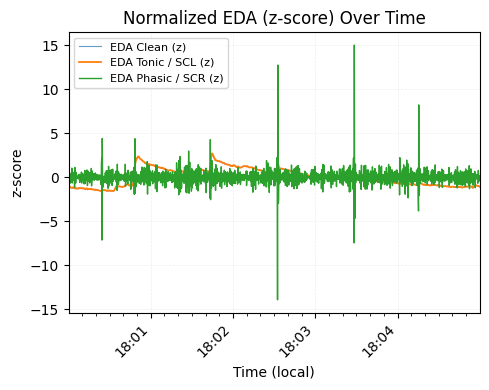

In [78]:
# ===== 画图 (optional) =====

time_col = "timestamp"  

# -----------------------
# 1. 检查 normalized 列是否存在
# -----------------------
norm_cols = ["EDA_Clean_z", "EDA_Tonic_z", "EDA_Phasic_z"]
available_cols = [c for c in norm_cols if c in df_downsampled.columns]

if len(available_cols) == 0:
    raise ValueError("No normalized EDA columns found. Did you run the normalization step?")

# -----------------------
# 2. 取时间戳并计算图宽
# -----------------------
x = df_downsampled[time_col]

start_time = x.min()
end_time = x.max()

duration_seconds = max((end_time - start_time).total_seconds(), 1)
width = duration_seconds * (1 / 60)  # 与前两个plot保持一致：秒→分钟作为宽度 scaling

# -----------------------
# 3. 开始画图
# -----------------------
fig, ax = plt.subplots(figsize=(width, 4))

#plot
if "EDA_Clean_z" in available_cols:
    ax.plot(x, df_downsampled["EDA_Clean_z"], label="EDA Clean (z)", alpha=0.7, linewidth=0.8)

if "EDA_Tonic_z" in available_cols:
    ax.plot(x, df_downsampled["EDA_Tonic_z"], label="EDA Tonic / SCL (z)", linewidth=1.3)

if "EDA_Phasic_z" in available_cols:
    ax.plot(x, df_downsampled["EDA_Phasic_z"], label="EDA Phasic / SCR (z)", linewidth=1)

# legend
ax.legend(fontsize=8)

# labels
ax.set_title("Normalized EDA (z-score) Over Time", fontsize=12)
ax.set_xlabel("Time (local)")
ax.set_ylabel("z-score")

# grid（与前面 plot 1 / plot 3 对齐）
ax.grid(alpha=0.2, linestyle="--", linewidth=0.5)

# tick style
ax.tick_params(labelsize=10)

# x-axis formatting（分钟主刻度 + 秒级次刻度）
eastern = pytz.timezone("US/Eastern")
ax.set_xlim(start_time, end_time)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M", tz=eastern))
ax.xaxis.set_minor_locator(mdates.SecondLocator(bysecond=range(0, 60, 10)))

plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()


In [139]:
# ==== Step: 计算 EDA Sliding-window variability (类似 HRV 的 EDAV) ====

# 采样率（如果上面已经有 FS / sampling_rate，可以直接用）
FS = 5  # 或直接 FS = 5

time_col = "timestamp"   # 如果你有 timestamp_local 就改成那个

# 窗口长度（秒）——可以自由改，比如 5、10、20 秒
WINDOW_SEC = 5
window_samples = max(int(WINDOW_SEC * FS), 1)

print(f"Using window = {WINDOW_SEC}s ({window_samples} samples) for sliding std.")

# 选择用哪一列来做 variability：优先用 z-score，方便不同人对比
if "EDA_Clean_z" in df_downsampled.columns:
    base_col = "EDA_Clean_z"
else:
    base_col = "EDA_Clean"

# 计算滚动标准差（滑动窗口变异度）
var_col_name = f"{base_col}_std_{WINDOW_SEC}s"
df_downsampled[var_col_name] = (
    df_downsampled[base_col]
    .rolling(window=window_samples, center=True)
    .std()
)

print(f"✅ Added variability column: {var_col_name}")

# 如需导出新的 CSV（可选）
output_csv_path = CSV_PATH.with_name(CSV_PATH.stem + f"_eda_with_variability_{WINDOW_SEC}s.csv")
df_downsampled.to_csv(output_csv_path, index=False)
print(f"💾 CSV with variability saved to: {output_csv_path}")
df_downsampled.head()


Using window = 5s (25 samples) for sliding std.
✅ Added variability column: EDA_Clean_z_std_5s
💾 CSV with variability saved to: /Users/jianingyu/Downloads/Design_Analytics/data_analysis_final/csv_data/1210AWU-G4/data_analysis_final_raw_eda_with_variability_5s.csv


,timestamp_local,index,timestamp,acc_x_g,acc_y_g,acc_z_g,eda_uS,temperature_c,bvp,EDA_Clean,EDA_Tonic,EDA_Phasic,EDA_Clean_z,EDA_Tonic_z,EDA_Phasic_z,EDA_Clean_z_std_5s
0,2025-12-10 17:38:00-05:00,13.5,2025-12-10 17:38:00.097920256-05:00,-0.014490,0.451550,0.903288,0.073582,31.507812,0.010945,0.073852,0.073987,-0.000135,-0.960153,-0.948258,-0.300236,NaN
1,2025-12-10 17:38:00.200000-05:00,40.5,2025-12-10 17:38:00.300739584-05:00,-0.012238,0.449260,0.902087,0.074893,NaN,0.017345,0.074594,0.074233,0.000361,-0.860249,-0.914883,0.801155,NaN
2,2025-12-10 17:38:00.400000-05:00,67.5,2025-12-10 17:38:00.500809984-05:00,-0.014640,0.452451,0.900698,0.073087,NaN,-0.024888,0.073529,0.073736,-0.000207,-1.003528,-0.982239,-0.458954,NaN
3,2025-12-10 17:38:00.600000-05:00,94.0,2025-12-10 17:38:00.698996992-05:00,-0.011265,0.449082,0.903979,NaN,NaN,-0.003920,0.073187,0.073190,-0.000002,-1.049461,-1.056199,-0.004630,NaN
4,2025-12-10 17:38:00.800000-05:00,120.0,2025-12-10 17:38:00.894729216-05:00,-0.011299,0.449260,0.902725,0.073262,NaN,0.024956,0.072885,0.072778,0.000107,-1.090136,-1.111951,0.238041,NaN


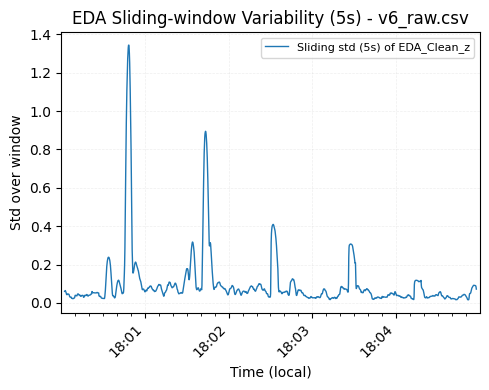

In [80]:
# ===== 画图 (optional) =====
time_col = "timestamp"   # 或 "timestamp_local"
var_col_name = f"{base_col}_std_{WINDOW_SEC}s"

if time_col not in df_downsampled.columns:
    raise ValueError(f"Time column '{time_col}' not found in processed")

if var_col_name not in df_downsampled.columns:
    raise ValueError(f"Variability column '{var_col_name}' not found. Run the previous cell first.")

x = df_downsampled[time_col]
y = df_downsampled[var_col_name]

# 计算时间长度 & 图宽
start_time = x.min()
end_time = x.max()
duration_seconds = max((end_time - start_time).total_seconds(), 1)
width = duration_seconds * (1 / 60)  # 和前面保持一致：按分钟比例放大宽度

fig, ax = plt.subplots(figsize=(width, 4))

ax.plot(x, y, linewidth=1, label=f"Sliding std ({WINDOW_SEC}s) of {base_col}")

ax.set_title(f"EDA Sliding-window Variability ({WINDOW_SEC}s) - {CSV_PATH.name}")
ax.set_xlabel("Time (local)")
ax.set_ylabel("Std over window")

# 网格 & 样式
ax.grid(alpha=0.2, linestyle="--", linewidth=0.5)
ax.tick_params(labelsize=10)

# 时间轴格式（与前面统一）
eastern = pytz.timezone("US/Eastern")
ax.set_xlim(start_time, end_time)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M", tz=eastern))
ax.xaxis.set_minor_locator(mdates.SecondLocator(bysecond=range(0, 60, 10)))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

In [140]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import os
from pathlib import Path

TIME_COL = "timestamp_local"
df = df_downsampled.copy()
df["Time"] = pd.to_datetime(df[TIME_COL]).dt.tz_localize(None)

subject_name = CSV_PATH.stem  # 例如 ASH1206

# ==== 事件表：视频 blocks ====
EVENT_CSV_PATH = Path("/Users/jianingyu/Downloads/Design_Analytics/data_analysis_final/csv_data/1210AWU-G4/events.csv")
events = pd.read_csv(EVENT_CSV_PATH)

def parse_event_time(series, global_start):
    """
    自动解析 events 里的时间列：
    - 如果本身就带日期(YYYY-MM-DD HH:MM:SS)，直接解析
    - 如果只有 HH:MM:SS，则加上 global_start 的日期
    """
    s = series.astype(str).str.strip()
    has_date = s.str.len().gt(8).any()  # 长度 > 8 基本说明包含日期

    if has_date:
        return pd.to_datetime(s).dt.tz_localize(None)
    else:
        date_str = global_start.strftime("%Y-%m-%d")
        return pd.to_datetime(date_str + " " + s)

# ==== 全局时间范围 ====
eda_start = df["Time"].min()
eda_end   = df["Time"].max()

# 解析事件时间
events["start_dt"] = parse_event_time(events["start_time"], eda_start)
events["end_dt"]   = parse_event_time(events["end_time"],   eda_start)

global_start = min(eda_start, events["start_dt"].min())
global_end   = max(eda_end,   events["end_dt"].max())

# ==== 颜色：按 A/B/C/D 分类 ====
category_color_map = {
    "A": "rgba(255, 182, 193, 0.70)",  # 粉
    "B": "rgba(173, 216, 230, 0.70)",  # 蓝
    "C": "rgba(152, 251, 152, 0.70)",  # 绿
    "D": "rgba(216, 191, 216, 0.70)",  # 紫（暂时可能用不上，但先预留）
}

category_legend_label = {
    "A": "Video type A",
    "B": "Video type B",
    "C": "Video type C",
    "D": "Video type D",
}

# ==== 生成分钟刻度 ====
# start_minute = global_start.replace(second=0, microsecond=0)
# end_minute   = global_end.replace(second=0, microsecond=0) + pd.Timedelta(minutes=1)

# minute_ticks, minute_labels = [], []
# cur = start_minute
# while cur <= end_minute:
#     minute_ticks.append(cur)
#     minute_labels.append(cur.strftime("%H:%M"))
#     cur += pd.Timedelta(minutes=1)

# ==== 生成每 10 秒一个刻度 ====
start_sec = global_start.replace(microsecond=0)
end_sec   = global_end.replace(microsecond=0) + pd.Timedelta(seconds=30)

tick_interval = 30  # 每 10 秒一个 tick

sec_ticks, sec_labels = [], []
cur = start_sec
while cur <= end_sec:
    sec_ticks.append(cur)
    sec_labels.append(cur.strftime("%H:%M:%S"))
    cur += pd.Timedelta(seconds=tick_interval)


# ==== 创建 3 行 subplot ====
fig = make_subplots(
    rows=3,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.12,
    subplot_titles=[
        "EDA_Tonic_z",
        "EDA_Phasic_z",
        "EDA_Clean_z_std_5s",
    ],
)

# 1) EDA_Tonic_z
fig.add_trace(
    go.Scatter(
        x=df["Time"],
        y=df["EDA_Tonic_z"],
        mode="lines",
        name="EDA_Tonic_z",
        line=dict(width=1.2),
        hovertemplate="Time=%{x|%H:%M:%S}<br>EDA_Tonic_z=%{y:.3f}<extra></extra>",
    ),
    row=1, col=1
)

# 2) EDA_Phasic_z
fig.add_trace(
    go.Scatter(
        x=df["Time"],
        y=df["EDA_Phasic_z"],
        mode="lines",
        name="EDA_Phasic_z",
        line=dict(width=1.2),
        hovertemplate="Time=%{x|%H:%M:%S}<br>EDA_Phasic_z=%{y:.3f}<extra></extra>",
    ),
    row=2, col=1
)

# 3) EDA_Clean_z_std_5s
fig.add_trace(
    go.Scatter(
        x=df["Time"],
        y=df["EDA_Clean_z_std_5s"],
        mode="lines",
        name="EDA_Clean_z_std_5s",
        line=dict(width=1.2),
        hovertemplate="Time=%{x|%H:%M:%S}<br>Std(5s)=%{y:.3f}<extra></extra>",
    ),
    row=3, col=1
)

# ==== 每个 clip 一段彩色背景 ====
for _, row_ev in events.iterrows():
    cat = str(row_ev["category"]).strip()
    x0, x1 = row_ev["start_dt"], row_ev["end_dt"]
    color = category_color_map.get(cat, "rgba(200,200,200,0.20)")

    fig.add_vrect(
        x0=x0,
        x1=x1,
        fillcolor=color,
        opacity=float(color.split(",")[-1].strip(" )")) if "rgba" in color else 0.18,
        line_width=0,
        layer="below",
        yref="paper",
        y0=0,
        y1=1,
    )

# ==== legend 使用 A/B/C/D 的“虚拟 trace” ====
def rgba_to_rgb(color):
    if not isinstance(color, str) or not color.startswith("rgba"):
        return color
    nums = color[color.find("(")+1 : color.find(")")].split(",")
    r, g, b = [int(float(c)) for c in nums[:3]]
    return f"rgba({r},{g},{b}, 0.50)"

used_categories = [c for c in events["category"].astype(str).unique()
                   if c in category_color_map]

for cat in used_categories:
    base_color = category_color_map[cat]
    rgb_color  = rgba_to_rgb(base_color)
    label      = category_legend_label.get(cat, cat)

    fig.add_trace(
        go.Scatter(
            x=[global_end],
            y=[None],
            mode="lines",
            line=dict(color=rgb_color, width=10),
            name=label,
            showlegend=True,
        ),
        row=1, col=1,
    )

# ==== layout ====
fig.update_layout(
    title=dict(text=f"EDA Overview - G4_P2 (Video blocks)", font=dict(size=18)),
    width=1400,
    height=3 * 350,
    hovermode="x unified",
    plot_bgcolor="white",
    paper_bgcolor="white",
    margin=dict(l=80, r=200, t=80, b=80),
    legend=dict(
        title="Video categories",
        orientation="v",
        x=1.02,
        xanchor="left",
        y=1.0,
        yanchor="top",
        bordercolor="lightgray",
        borderwidth=1,
        bgcolor="rgba(255,255,255,0.8)",
        font=dict(size=11),
    ),
)

fig.update_yaxes(title_text="EDA_Tonic_z",       row=1, col=1, showgrid=True, gridcolor="#e0e0e0")
fig.update_yaxes(title_text="EDA_Phasic_z",      row=2, col=1, showgrid=True, gridcolor="#e0e0e0")
fig.update_yaxes(title_text="Std (z-score, 5s)", row=3, col=1, showgrid=True, gridcolor="#e0e0e0")

for r in range(1, 4):
    fig.update_xaxes(
        row=r, col=1,
        type="date",
        showgrid=True,
        gridcolor="#e0e0e0",
        tickmode="array",
        tickvals=sec_ticks,
        ticktext=sec_labels,
        tickangle=-45,
        tickformat="%H:%M:%S",
        range=[global_start, global_end],
        showticklabels=True,
    )

fig.update_xaxes(title_text="Time (local)", row=3, col=1)

# ==== 保存 ====
out_dir = os.path.join(os.path.dirname(str(CSV_PATH)), "charts_eda")
os.makedirs(out_dir, exist_ok=True)

html_path = os.path.join(out_dir, f"{subject_name}_EDA_video_blocks.html")
png_path  = os.path.join(out_dir, f"{subject_name}_EDA_video_blocks.png")

fig.write_html(html_path, include_plotlyjs="cdn")
print(f"HTML saved: {html_path}")

try:
    fig.write_image(png_path, scale=2)
    print(f"PNG saved: {png_path}")
except Exception as e:
    print(f"[WARN] PNG not saved (install kaleido?): {e}")


HTML saved: /Users/jianingyu/Downloads/Design_Analytics/data_analysis_final/csv_data/1210AWU-G4/charts_eda/data_analysis_final_raw_EDA_video_blocks.html
PNG saved: /Users/jianingyu/Downloads/Design_Analytics/data_analysis_final/csv_data/1210AWU-G4/charts_eda/data_analysis_final_raw_EDA_video_blocks.png


In [29]:
import numpy as np

# 确保 df 里有时间列
df = df_downsampled.copy()
df["Time"] = pd.to_datetime(df[TIME_COL]).dt.tz_localize(None)

# 如果还没解析 start_dt / end_dt，就先解析（否则可以跳过这一段）
# events = pd.read_csv(EVENT_CSV_PATH)
# events["start_dt"] = parse_event_time(events["start_time"], df["Time"].min())
# events["end_dt"]   = parse_event_time(events["end_time"],   df["Time"].min())

summary_rows = []

eda_cols = ["EDA_Tonic_z", "EDA_Phasic_z", "EDA_Clean_z_std_5s"]  # 想算哪几个就放哪几个

for _, ev in events.iterrows():
    start = ev["start_dt"]
    end   = ev["end_dt"]

    # 取出这个视频对应时间段的 EDA
    mask = (df["Time"] >= start) & (df["Time"] <= end)
    seg  = df.loc[mask, eda_cols]

    # 如果这一段没有数据，就填 NaN 并跳过或继续
    if seg.empty:
        print(f"[WARN] no EDA data for block {ev['block']} clip {ev['clip_index']}")
        row = {
            "block": ev["block"],
            "clip_index": ev["clip_index"],
            "video_id": ev["video_id"],
            "category": ev["category"],
            "start_dt": start,
            "end_dt": end,
            "duration_sec": (end - start).total_seconds(),
            "n_samples": 0,
        }
        for col in eda_cols:
            row[f"{col}_mean"] = np.nan
            row[f"{col}_std"]  = np.nan
        summary_rows.append(row)
        continue

    row = {
        "block": ev["block"],
        "clip_index": ev["clip_index"],
        "video_id": ev["video_id"],
        "category": ev["category"],
        "start_dt": start,
        "end_dt": end,
        "duration_sec": (end - start).total_seconds(),
        "n_samples": len(seg),
    }

    # 对每个 EDA 列计算 mean + std
    for col in eda_cols:
        row[f"{col}_mean"] = seg[col].mean()
        row[f"{col}_std"]  = seg[col].std()

    summary_rows.append(row)

eda_summary = pd.DataFrame(summary_rows)
eda_summary.head()


,block,clip_index,video_id,category,start_dt,end_dt,duration_sec,n_samples,EDA_Tonic_z_mean,EDA_Tonic_z_std,EDA_Phasic_z_mean,EDA_Phasic_z_std,EDA_Clean_z_std_5s_mean,EDA_Clean_z_std_5s_std
0,1,1,4,A,2025-12-06 18:00:45,2025-12-06 18:00:54,9.0,46,1.987641,1.318949,-0.000036,0.762271,0.619937,0.456802
1,1,2,6,C,2025-12-06 18:01:31,2025-12-06 18:01:40,9.0,46,1.573304,0.270289,0.000519,0.492594,0.157328,0.091274
2,1,3,1,A,2025-12-06 18:02:03,2025-12-06 18:02:11,8.0,41,2.125277,0.059652,-0.006885,0.343210,0.058166,0.011659
3,1,4,2,B,2025-12-06 18:02:27,2025-12-06 18:02:35,8.0,41,1.608241,0.347846,-0.025334,2.477154,0.220770,0.157084
4,1,5,5,B,2025-12-06 18:02:56,2025-12-06 18:03:04,8.0,41,1.100117,0.030571,-0.000493,0.359010,0.027205,0.002469


In [30]:
out_dir = os.path.join(os.path.dirname(str(CSV_PATH)), "clip_stats")
os.makedirs(out_dir, exist_ok=True)

summary_path = os.path.join(out_dir, f"{subject_name}_EDA_video_clip_stats.csv")
eda_summary.to_csv(summary_path, index=False)
print("Saved clip-level EDA stats to:", summary_path)


Saved clip-level EDA stats to: /Users/jianingyu/Downloads/Design_Analytics/data_analysis_final/csv_data/1206ASH-G1/clip_stats/v6_raw_EDA_video_clip_stats.csv


In [32]:
import plotly.express as px

fig = px.box(
    eda_summary,
    x="clip_index",
    y="EDA_Clean_z_std_5s_mean",
    color="category",          # 可选，不想使用就删掉
    title="EDA 波动（Mean）随视频播放顺序（clip_index）变化",
    points="all"               # 显示散点
)

fig.update_layout(
    xaxis_title="Clip Index (1–8)",
    yaxis_title="EDA Fluctuation (Mean of Clean_z_std_5s)",
    font=dict(size=12)
)

fig.show()


In [8]:
# ==== EDA stacked HTML (with colored events & legend) ====

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import os
from pathlib import Path

TIME_COL = "timestamp_local"   # 如果要用别的时间列就改这里
df = df_downsampled.copy()
df["Time"] = pd.to_datetime(df[TIME_COL]).dt.tz_localize(None)

subject_name = CSV_PATH.stem

# ==== 事件表（和 breathing 版本共用一套逻辑） ====
# ⭐⭐⭐ 把这里改成你实际的 events.csv 路径
EVENT_CSV_PATH = Path("visualizations/MARCELLA1118/events.csv")

events = pd.read_csv(EVENT_CSV_PATH)

def parse_event_time(series, global_start):
    """
    自动解析 events 里的时间列：
    - 如果本身就带日期，直接解析
    - 如果只有 HH:MM:SS，则加上 global_start 的日期
    """
    s = series.astype(str).str.strip()
    has_date = s.str.len().gt(8).any()  # 长度 > 8 基本说明包含日期

    if has_date:
        return pd.to_datetime(s).dt.tz_localize(None)
    else:
        date_str = global_start.strftime("%Y-%m-%d")
        return pd.to_datetime(date_str + " " + s)

# 全局时间范围：用 EDA 和 events 一起算（防止事件比 EDA 早/晚）
eda_start = df["Time"].min()
eda_end   = df["Time"].max()

# 先填充 end_time，避免 NaN
events["end_time"] = events["end_time"].fillna(method="bfill")
events["end_time"] = events["end_time"].fillna(events["start_time"])

events["start_dt"] = parse_event_time(events["start_time"], eda_start)
events["end_dt"]   = parse_event_time(events["end_time"],   eda_start)

global_start = min(eda_start, events["start_dt"].min())
global_end   = max(eda_end,   events["end_dt"].max())

# 用 phase 聚合，得到每个 phase 的整体时间段
phase_ranges = (
    events.groupby("phase")[["start_dt", "end_dt"]]
    .agg({"start_dt": "min", "end_dt": "max"})
    .reset_index()
)

phase_color_map = {
    "warmup_baseline": "rgba(255, 182, 193, 0.50)",  # warm up drive
    "calm_baseline":   "rgba(255, 255, 153, 0.50)",  # warm up calm
    "drive_no_scent":  "rgba(173, 216, 230, 0.50)",  # baseline drive no scent
    "calm_no_scent":   "rgba(152, 251, 152, 0.50)",  # baseline calm no scent
    "drive_scent":     "rgba(216, 191, 216, 0.50)",  # experiment drive with scent
    "calm_scent":      "rgba(255, 228, 196, 0.50)",  # calm with scent B
    "rewatch_scent":   "rgba(224, 255, 255, 0.80)",
    "rewatch_no_scent":"rgba(224, 255, 255, 0.80)",
}

phase_legend_label = {
    "warmup_baseline": "Warm-up driving",
    "calm_baseline":   "Warm-up calming",
    "drive_no_scent":  "Baseline driving (no scent)",
    "calm_no_scent":   "Baseline calming (no scent)",
    "drive_scent":     "Driving with Scent A",
    "calm_scent":      "Calm with Scent B",
    "rewatch_scent":   "Rewatch with Scent A",
    "rewatch_no_scent":"Rewatch (no scent)",
}

# ==== 生成分钟刻度（用 global_start / global_end） ====
start_minute = global_start.replace(second=0, microsecond=0)
end_minute   = global_end.replace(second=0, microsecond=0) + pd.Timedelta(minutes=1)

minute_ticks, minute_labels = [], []
cur = start_minute
while cur <= end_minute:
    minute_ticks.append(cur)
    minute_labels.append(cur.strftime("%H:%M"))
    cur += pd.Timedelta(minutes=1)

# ==== 创建 3 行 subplot（只有 EDA） ====
fig = make_subplots(
    rows=3,
    cols=1,
    shared_xaxes=True,          # 时间对齐
    vertical_spacing=0.06,
    subplot_titles=[
        "EDA_Tonic_z",
        "EDA_Phasic_z",
        "EDA_Clean_z_std_5s",
    ],
)

# 1) EDA_Tonic_z
fig.add_trace(
    go.Scatter(
        x=df["Time"],
        y=df["EDA_Tonic_z"],
        mode="lines",
        name="EDA_Tonic_z",
        line=dict(width=1),
        hovertemplate="Time=%{x|%H:%M:%S}<br>EDA_Tonic_z=%{y:.3f}<extra></extra>",
    ),
    row=1, col=1
)

# 2) EDA_Phasic_z
fig.add_trace(
    go.Scatter(
        x=df["Time"],
        y=df["EDA_Phasic_z"],
        mode="lines",
        name="EDA_Phasic_z",
        line=dict(width=1),
        hovertemplate="Time=%{x|%H:%M:%S}<br>EDA_Phasic_z=%{y:.3f}<extra></extra>",
    ),
    row=2, col=1
)

# 3) EDA_Clean_z_std_5s
fig.add_trace(
    go.Scatter(
        x=df["Time"],
        y=df["EDA_Clean_z_std_5s"],
        mode="lines",
        name="EDA_Clean_z_std_5s",
        line=dict(width=1),
        hovertemplate="Time=%{x|%H:%M:%S}<br>Std(5s)=%{y:.3f}<extra></extra>",
    ),
    row=3, col=1
)

# ==== 事件 phase 彩色背景（跨所有 subplot） ====
for _, row_ev in phase_ranges.iterrows():
    phase = row_ev["phase"]
    x0, x1 = row_ev["start_dt"], row_ev["end_dt"]
    color = phase_color_map.get(phase, "rgba(200,200,200,0.15)")

    fig.add_vrect(
        x0=x0,
        x1=x1,
        fillcolor=color,
        opacity=float(color.split(",")[-1].strip(" )")) if "rgba" in color else 0.18,
        line_width=0,
        layer="below",
        yref="paper",  # 👈 覆盖整张图的 y 方向（所有子图）
        y0=0,
        y1=1,
    )

# ==== 为 legend 添加“虚拟 trace” ====
def rgba_to_rgb(color):
    """把 'rgba(r,g,b,a)' 转成 'rgba(r,g,b,a_fixed)' 用于 legend 线条颜色"""
    if not isinstance(color, str) or not color.startswith("rgba"):
        return color
    nums = color[color.find("(")+1 : color.find(")")].split(",")
    r, g, b = [int(float(c)) for c in nums[:3]]
    return f"rgba({r},{g},{b}, 0.50)"

used_phases = [p for p in phase_ranges["phase"].unique() if p in phase_color_map]

for phase in used_phases:
    base_color = phase_color_map[phase]
    rgb_color  = rgba_to_rgb(base_color)
    label      = phase_legend_label.get(phase, phase)

    fig.add_trace(
        go.Scatter(
            x=[global_end],
            y=[None],
            mode="lines",
            line=dict(color=rgb_color, width=10),
            name=label,
            showlegend=True,
        ),
        row=1, col=1,
    )

# ==== 统一 layout ====
# ⭐⭐⭐ participant name from file path
fig.update_layout(
    title=dict(text=f"EDA Overview - MARCELLA1118", font=dict(size=18)),
    width=1400,
    height=3 * 350,   # 每个 subplot 大约 350 高度，可按需要调
    hovermode="x unified",
    plot_bgcolor="white",
    paper_bgcolor="white",
    margin=dict(l=80, r=200, t=80, b=80),
    legend=dict(
        title="Annotations",
        orientation="v",
        x=1.02,
        xanchor="left",
        y=1.0,
        yanchor="top",
        bordercolor="lightgray",
        borderwidth=1,
        bgcolor="rgba(255,255,255,0.8)",
        font=dict(size=11),
    ),
)

# y 轴标题
fig.update_yaxes(title_text="EDA_Tonic_z",       row=1, col=1, showgrid=True, gridcolor="#e0e0e0")
fig.update_yaxes(title_text="EDA_Phasic_z",      row=2, col=1, showgrid=True, gridcolor="#e0e0e0")
fig.update_yaxes(title_text="Std (z-score, 5s)", row=3, col=1, showgrid=True, gridcolor="#e0e0e0")

# x 轴：所有行都显示时间刻度
for r in range(1, 4):
    fig.update_xaxes(
        row=r, col=1,
        type="date",
        showgrid=True,
        gridcolor="#e0e0e0",
        tickmode="array",
        tickvals=minute_ticks,
        ticktext=minute_labels,
        tickangle=-45,
        tickformat="%H:%M",
        range=[global_start, global_end],
        showticklabels=True,
    )

fig.update_xaxes(title_text="Time (local)", row=3, col=1)

# ==== 保存 HTML + PNG ====
out_dir = os.path.join(os.path.dirname(str(CSV_PATH)), "charts_eda")
os.makedirs(out_dir, exist_ok=True)

html_path = os.path.join(out_dir, f"{subject_name}_EDA_all_in_one.html")
png_path  = os.path.join(out_dir, f"{subject_name}_EDA_all_in_one.png")

fig.write_html(html_path, include_plotlyjs="cdn")
print(f"HTML saved: {html_path}")

# PNG 需要 kaleido：pip install kaleido
try:
    fig.write_image(png_path, scale=2)
    print(f"PNG saved: {png_path}")
except Exception as e:
    print(f"[WARN] PNG not saved (install kaleido?): {e}")


/var/folders/22/0vpdqgyx5q717n66h48gjd500000gn/T/ipykernel_40209/2042368263.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  events["end_time"] = events["end_time"].fillna(method="bfill")


HTML saved: /Users/jianingyu/Downloads/MAS-S63_project/visualizations/MARCELLA1118/charts_eda/v6_raw_EDA_all_in_one.html


Resorting to unclean kill browser.


PNG saved: /Users/jianingyu/Downloads/MAS-S63_project/visualizations/MARCELLA1118/charts_eda/v6_raw_EDA_all_in_one.png


In [9]:
import pandas as pd
from pathlib import Path
import numpy as np

# ---- ⭐⭐⭐⭐⭐⭐ 读入 breathing 数据（如何这个participant没有收集到breathing data, 就跳过这个cell）----
BREATHING_CSV_PATH = Path("visualizations/MARCELLA1118/Breathing.csv")      # 呼吸数据
br_df = pd.read_csv(BREATHING_CSV_PATH)

br_df["Time"] = pd.to_datetime(br_df["Time"])
br_df["Time"] = br_df["Time"].dt.tz_localize(None)   # 去掉 tz，方便和 EDA 对齐

# ---- 估计采样率（Hz）：用相邻时间差的中位数反推 ----
dt_median = br_df["Time"].sort_values().diff().dt.total_seconds().median()
fs_br = 1.0 / dt_median
print(f"Estimated breathing sampling rate: {fs_br:.2f} Hz")

# ---- 定义窗口长度（秒）----
WINDOW_AMP_SEC = 5   # 计算振幅的窗口长度（可改，例如 5s / 10s）
WINDOW_VAR_SEC = 30  # 计算变异度的窗口长度（类似 30s HRV）

win_amp_samples = max(int(WINDOW_AMP_SEC * fs_br), 1)
win_var_samples = max(int(WINDOW_VAR_SEC * fs_br), 1)

print(f"Amplitude window: {win_amp_samples} samples ({WINDOW_AMP_SEC}s)")
print(f"Variability window: {win_var_samples} samples ({WINDOW_VAR_SEC}s)")

# ---- 1) 振幅：窗口内 max - min ----
def peak_to_peak(x):
    return np.max(x) - np.min(x)

br_df["BR_Amplitude"] = (
    br_df["BreathingWaveform"]
    .rolling(win_amp_samples, center=True)
    .apply(peak_to_peak, raw=True)
)

# ---- 2) 变异度：振幅的滚动 std（类似“呼吸深度的变异性”）----
br_df["BR_Variability"] = (
    br_df["BR_Amplitude"]
    .rolling(win_var_samples, center=True)
    .std()
)

# 可选：导出带特征的 breathing CSV 备用
breathing_out = BREATHING_CSV_PATH.with_name(BREATHING_CSV_PATH.stem + "_with_features.csv")
br_df.to_csv(breathing_out, index=False)
print(f"✅ Breathing features saved to: {breathing_out}")
br_df.head()


/var/folders/22/0vpdqgyx5q717n66h48gjd500000gn/T/ipykernel_40209/27913115.py:9: UserWarning:

Parsing dates in %d/%m/%Y %H:%M:%S.%f format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



Estimated breathing sampling rate: 25.00 Hz
Amplitude window: 125 samples (5s)
Variability window: 750 samples (30s)
✅ Breathing features saved to: visualizations/MARCELLA1118/Breathing_with_features.csv


,Time,BreathingWaveform,BR_Amplitude,BR_Variability
0,2025-11-18 09:46:27.406,2712371,NaN,NaN
1,2025-11-18 09:46:27.446,2721591,NaN,NaN
2,2025-11-18 09:46:27.486,2721591,NaN,NaN
3,2025-11-18 09:46:27.526,2694338,NaN,NaN
4,2025-11-18 09:46:27.566,2694338,NaN,NaN


In [13]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from pathlib import Path
import os

# ---- 基本输入 ----
### ⭐⭐⭐ participant name in title
TIME_COL_EDA   = "timestamp_local"
EVENT_CSV_PATH = Path("visualizations/MARCELLA1118/events.csv")   # 按前面说明准备好的 events.csv

eda_df = df_downsampled.copy()
eda_df["Time"] = pd.to_datetime(eda_df[TIME_COL_EDA]).dt.tz_localize(None)

# br_df 已在上一步创建，确保 Time 无时区
br_df["Time"] = pd.to_datetime(br_df["Time"]).dt.tz_localize(None)

subject_name = CSV_PATH.stem

# ---- 全局时间范围 ----
global_start = min(eda_df["Time"].min(), br_df["Time"].min())
global_end   = max(eda_df["Time"].max(), br_df["Time"].max())

# 分钟刻度
start_minute = global_start.replace(second=0, microsecond=0)
end_minute   = global_end.replace(second=0, microsecond=0) + pd.Timedelta(minutes=1)

minute_ticks, minute_labels = [], []
cur = start_minute
while cur <= end_minute:
    minute_ticks.append(cur)
    minute_labels.append(cur.strftime("%H:%M"))
    cur += pd.Timedelta(minutes=1)

# ---- 事件表 ----
events = pd.read_csv(EVENT_CSV_PATH)

def parse_event_time(series, global_start):
    """自动解析 events 里的时间列：
       - 如果本身就带日期，直接解析
       - 如果只有 HH:MM:SS，则加上 global_start 的日期
    """
    s = series.astype(str).str.strip()
    # 粗暴判断：长度 > 8 基本就说明包含日期信息
    has_date = s.str.len().gt(8).any()

    if has_date:
        # 直接当完整 datetime 解析
        return pd.to_datetime(s).dt.tz_localize(None)
    else:
        date_str = global_start.strftime("%Y-%m-%d")
        return pd.to_datetime(date_str + " " + s)

# 先补全 end_time
events["end_time"] = events["end_time"].fillna(method="bfill")
events["end_time"] = events["end_time"].fillna(events["start_time"])

events["start_dt"] = parse_event_time(events["start_time"], global_start)
events["end_dt"]   = parse_event_time(events["end_time"], global_start)


phase_ranges = (
    events.groupby("phase")[["start_dt", "end_dt"]]
    .agg({"start_dt": "min", "end_dt": "max"})
    .reset_index()
)

phase_color_map = {
    "warmup_baseline": "rgba(255, 182, 193, 0.50)",  # warm up drive
    "calm_baseline":   "rgba(255, 255, 153, 0.50)",  # warm up calm
    "drive_no_scent":  "rgba(173, 216, 230, 0.50)",  # baseline drive no scent
    "calm_no_scent":   "rgba(152, 251, 152, 0.50)",  # baseline calm no scent
    "drive_scent":     "rgba(216, 191, 216, 0.50)",  # experiment drive with scent
    # "calm_scent":    "rgba(255, 228, 196, 0.50)",  # calm with scent A
    "calm_scent":    "rgba(255, 228, 196, 0.50)",  # calm with scent B
    "rewatch_scent": "rgba(224, 255, 255, 0.80)",
    "rewatch_no_scent":"rgba(224, 255, 255, 0.80)",
}

phase_legend_label = {
    "warmup_baseline": "Warm-up driving",
    "calm_baseline":   "Warm-up calming",
    "drive_no_scent":  "Baseline driving (no scent)",
    "calm_no_scent":   "Baseline calming (no scent)",
    "drive_scent":     "Driving with scent A",
    "calm_scent":    "Calm with Scent B",
    "rewatch_scent": "Rewatch with Scent A",
    "rewatch_no_scent":"Rewatch (no scent)",
}

# ---- 6 行 subplot：3 个 breathing + 3 个 EDA ----
fig = make_subplots(
    rows=6,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.06,
    subplot_titles=[
        # "Breathing Waveform",
        "EDA_SCL (normalized)",
        "EDA_SCR (normalized)",
        "EDA_Variability (5s window)",
        "Breathing Amplitude ({}s window)".format(WINDOW_AMP_SEC),
        "Breathing Variability ({}s window)".format(WINDOW_VAR_SEC),
    ],
)

# Row 1: waveform

# Row 1: EDA_Tonic_z
fig.add_trace(
    go.Scatter(
        x=eda_df["Time"],
        y=eda_df["EDA_Tonic_z"],
        mode="lines",
        name="EDA_SCL (normalized)",
        line=dict(width=1),
        hovertemplate="Time=%{x|%H:%M:%S}<br>EDA_Tonic_z=%{y:.3f}<extra></extra>",
    ),
    row=1, col=1
)

# Row 2: EDA_Phasic_z
fig.add_trace(
    go.Scatter(
        x=eda_df["Time"],
        y=eda_df["EDA_Phasic_z"],
        mode="lines",
        name="EDA_SCR (normalized)",
        line=dict(width=1),
        hovertemplate="Time=%{x|%H:%M:%S}<br>EDA_Phasic_z=%{y:.3f}<extra></extra>",
    ),
    row=2, col=1
)

# Row 3: EDA_Clean_z_std_5s
fig.add_trace(
    go.Scatter(
        x=eda_df["Time"],
        y=eda_df["EDA_Clean_z_std_5s"],
        mode="lines",
        name="EDA_Variability (5s window)",
        line=dict(width=1),
        hovertemplate="Time=%{x|%H:%M:%S}<br>Std(5s)=%{y:.3f}<extra></extra>",
    ),
    row=3, col=1
)

# Row 4: amplitude
fig.add_trace(
    go.Scatter(
        x=br_df["Time"],
        y=br_df["BR_Amplitude"],
        mode="lines",
        name="BR_Amplitude",
        line=dict(width=1),
        hovertemplate="Time=%{x|%H:%M:%S}<br>Amp=%{y:.2f}<extra></extra>",
    ),
    row=4, col=1
)

# Row 5: variability
fig.add_trace(
    go.Scatter(
        x=br_df["Time"],
        y=br_df["BR_Variability"],
        mode="lines",
        name="BR_Variability",
        line=dict(width=1),
        hovertemplate="Time=%{x|%H:%M:%S}<br>Var=%{y:.2f}<extra></extra>",
    ),
    row=5, col=1
)

# ---- Layout & axes ----
### ⭐⭐⭐ participant name in title
fig.update_layout(
    title=dict(text=f"EDA + Breathing (Amplitude & Variability) - MARCELLA1118", font=dict(size=18)),
    width=1700,
    height=6 * 320,
    hovermode="x unified",
    plot_bgcolor="white",
    paper_bgcolor="white",
    margin=dict(l=80, r=40, t=80, b=80),
)

y_titles = [
    "z-score (tonic)",
    "z-score (phasic)",
    "Std (z-score)",
    "Amplitude",
    "Variability",
]
for r, ylab in enumerate(y_titles, start=1):
    fig.update_yaxes(title_text=ylab, row=r, col=1, showgrid=True, gridcolor="#e0e0e0")

for r in range(1, 7):   # 有几行 subplot 就写几
    fig.update_xaxes(
        row=r,
        col=1,
        type="date",
        showgrid=True,
        gridcolor="#e0e0e0",

        # 👇 每分钟一个刻度（我们自己算好的 minute_ticks / minute_labels）
        tickmode="array",
        tickvals=minute_ticks,      # 每个元素是一个分钟级 datetime
        ticktext=minute_labels,     # 对应的 "HH:MM" 字符串

        tickformat="%H:%M",        # hover 里仍然可以显示秒
        tickangle=-45,
        range=[global_start, global_end],
        showticklabels=True,       # 🔴 每一行都显示刻度标签
    )

# 只在最后一行加 x 轴标题（可选）
fig.update_xaxes(title_text="Time (local)", row=6, col=1)

# ---- 事件 phase 彩色背景 ----
for _, row in phase_ranges.iterrows():
    phase = row["phase"]
    x0, x1 = row["start_dt"], row["end_dt"]
    color = phase_color_map.get(phase, "rgba(200,200,200,0.15)")

    fig.add_vrect(
        x0=x0,
        x1=x1,
        fillcolor=color,
        opacity=float(color.split(",")[-1].strip(" )")) if "rgba" in color else 0.18,
        line_width=0,
        layer="below",
    )

# ==== 在右侧创建 phase legend（用虚拟 trace）====

def rgba_to_rgb(color):
    """把 'rgba(r,g,b,a)' 转成 'rgb(r,g,b)' 用于 legend 线条颜色"""
    if not isinstance(color, str) or not color.startswith("rgba"):
        return color
    nums = color[color.find("(")+1 : color.find(")")].split(",")
    r, g, b = [int(float(c)) for c in nums[:3]]
    return f"rgba({r},{g},{b}, 0.50)"

# 为每种 phase 添加一个“虚拟 trace”供 legend 使用
used_phases = [p for p in phase_ranges["phase"].unique() if p in phase_color_map]

for phase in used_phases:
    base_color = phase_color_map[phase]
    rgb_color  = rgba_to_rgb(base_color)
    label      = phase_legend_label.get(phase, phase)

    fig.add_trace(
        go.Scatter(
            x=[global_end],      # 放在图外边的一个点（不会影响曲线）
            y=[None],
            mode="lines",
            line=dict(color=rgb_color, width=10),
            name=label,
            showlegend=True,
        ),
        row=1, col=1,   # 放哪一行都可以，重点是只为了出现在 legend 里
    )

# 调整 legend 的位置到右侧竖排
fig.update_layout(
    legend=dict(
        title="Annotations",
        orientation="v",
        x=1.02,
        xanchor="left",
        y=1.0,
        yanchor="top",
        bordercolor="lightgray",
        borderwidth=1,
        bgcolor="rgba(255,255,255,0.8)",
        font=dict(size=11),
    )
)

    

# ---- 保存 ----
out_dir = os.path.join(os.path.dirname(str(CSV_PATH)), "charts_combined")
os.makedirs(out_dir, exist_ok=True)

html_path = os.path.join(out_dir, f"{subject_name}_Breathing_EDA_full.html")
png_path  = os.path.join(out_dir, f"{subject_name}_Breathing_EDA_full.png")

fig.write_html(html_path, include_plotlyjs="cdn")
print(f"HTML saved: {html_path}")

try:
    fig.write_image(png_path, scale=2)
    print(f"PNG saved: {png_path}")
except Exception as e:
    print(f"[WARN] PNG not saved: {e}")


/var/folders/22/0vpdqgyx5q717n66h48gjd500000gn/T/ipykernel_40209/2960813781.py:55: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



HTML saved: /Users/jianingyu/Downloads/MAS-S63_project/visualizations/MARCELLA1118/charts_combined/v6_raw_Breathing_EDA_full.html
PNG saved: /Users/jianingyu/Downloads/MAS-S63_project/visualizations/MARCELLA1118/charts_combined/v6_raw_Breathing_EDA_full.png


## Step 2: 条件对比（scent vs no-scent）
### 包括：
#### 1. 按 phase 提取数据
#### 2. 把 scent/no-scent 条件抽出来
#### 3. 计算 summary features
#### 4. 做统计检验
#### 5. 可视化对比图（boxplot or violin）   

In [16]:
import pandas as pd
import numpy as np
from pathlib import Path

# ========= 0. 时间标准化：统一成 tz-naive =========

# 1) EDA 时间列：从 processed 里拿 timestamp_local，去掉时区
eda_df = df_downsampled.copy()
eda_df["Time"] = (
    eda_df["timestamp_local"]
    .astype(str)        # 例如 "2025-11-20 12:12:25-05:00"
    .str.slice(0, 19)   # 只保留 "YYYY-MM-DD HH:MM:SS"
)
eda_df["Time"] = pd.to_datetime(eda_df["Time"])  # tz-naive

# 2) Breathing 时间列：如果也有时区，同样处理
#    如果你的 Breathing.csv 里本来就是没有时区的，可以只 pd.to_datetime 即可
br_df["Time"] = (
    br_df["Time"]
    .astype(str)
    .str.slice(0, 19)
)
br_df["Time"] = pd.to_datetime(br_df["Time"])    # tz-naive

print("EDA Time range:", eda_df["Time"].min(), "→", eda_df["Time"].max())
print("BR  Time range:", br_df["Time"].min(), "→", br_df["Time"].max())

# ========= 1. 读入 events.csv，并生成 start_dt / end_dt =========
### ⭐⭐⭐ participant name in title
EVENT_CSV_PATH = Path("visualizations/MARCELLA1118/events.csv")
events = pd.read_csv(EVENT_CSV_PATH)

# 你的 events.csv 里 start_time / end_time 已经是 "2025-11-20 12:12:25" 这种格式
events["start_dt"] = pd.to_datetime(events["start_time"])
events["end_dt"]   = pd.to_datetime(events["end_time"])

print("\nEvents head:")
print(events[["phase", "start_dt", "end_dt"]].head())

# 按 phase 合并成连续区间
phase_ranges = (
    events.groupby("phase")[["start_dt", "end_dt"]]
    .agg({"start_dt": "min", "end_dt": "max"})
    .reset_index()
)

print("\nPhase ranges:")
print(phase_ranges)

# ========= 2. 合并 EDA + Breathing（按时间对齐） =========

df = pd.merge_asof(
    eda_df.sort_values("Time"),
    br_df.sort_values("Time"),
    on="Time",
    direction="nearest",
    tolerance=pd.Timedelta(seconds=1)
)

# ========= 3. 为每一行打上 phase 标签 =========

def find_phase(t, ranges):
    for _, row in ranges.iterrows():
        if row["start_dt"] <= t <= row["end_dt"]:
            return row["phase"]
    return None

df["phase"] = df["Time"].apply(lambda t: find_phase(t, phase_ranges))

print("\nPhase value counts:")
print(df["phase"].value_counts(dropna=False))
df.head()


EDA Time range: 2025-11-18 09:50:00 → 2025-11-18 10:49:59
BR  Time range: 2025-11-18 09:46:27 → 2025-11-18 10:53:42

Events head:
             phase            start_dt              end_dt
0  warmup_baseline 2025-11-18 09:53:00 2025-11-18 10:12:00
1    calm_baseline 2025-11-18 10:18:17 2025-11-18 10:20:17
2      drive_scent 2025-11-18 10:39:55 2025-11-18 10:42:00
3      drive_scent 2025-11-18 10:40:59 2025-11-18 10:40:59
4      drive_scent 2025-11-18 10:43:30 2025-11-18 10:43:30

Phase ranges:
              phase            start_dt              end_dt
0     calm_baseline 2025-11-18 10:18:17 2025-11-18 10:20:17
1     calm_no_scent 2025-11-18 10:28:12 2025-11-18 10:30:12
2        calm_scent 2025-11-18 10:44:00 2025-11-18 10:46:00
3    drive_no_scent 2025-11-18 10:25:14 2025-11-18 10:28:00
4       drive_scent 2025-11-18 10:39:55 2025-11-18 10:45:30
5  rewatch_no_scent 2025-11-18 10:36:33 2025-11-18 10:39:19
6     rewatch_scent 2025-11-18 10:50:02 2025-11-18 10:53:03
7   warmup_baseline 2

,timestamp_local,index,timestamp,acc_x_g,acc_y_g,acc_z_g,eda_uS,temperature_c,bvp,EDA_Clean,...,EDA_Phasic,EDA_Clean_z,EDA_Tonic_z,EDA_Phasic_z,EDA_Clean_z_std_5s,Time,BreathingWaveform,BR_Amplitude,BR_Variability,phase
0,2025-11-18 09:50:00-05:00,66.5,2025-11-18 09:50:00.507399424-05:00,0.151654,0.963830,-0.211556,0.079029,28.976562,0.041898,0.079005,...,0.000019,-0.846904,-0.847114,0.440384,NaN,2025-11-18 09:50:00,3473981,949275.0,1.428212e+06,None
1,2025-11-18 09:50:01-05:00,200.5,2025-11-18 09:50:01.506091776-05:00,0.058453,0.866429,-0.511729,0.079739,28.992188,-0.006073,0.079734,...,-0.000037,-0.839087,-0.838687,-0.850330,NaN,2025-11-18 09:50:01,3422938,889317.0,1.328570e+06,None
2,2025-11-18 09:50:02-05:00,335.0,2025-11-18 09:50:02.508534528-05:00,0.064866,0.856181,-0.521710,0.076706,28.992188,-0.009214,0.076955,...,-0.000044,-0.868889,-0.868416,-1.003848,NaN,2025-11-18 09:50:02,3274294,515823.0,1.214378e+06,None
3,2025-11-18 09:50:03-05:00,469.5,2025-11-18 09:50:03.507936-05:00,0.050195,0.996908,-0.159423,0.074117,29.007812,0.010725,0.073966,...,0.000070,-0.900932,-0.901683,1.584930,NaN,2025-11-18 09:50:03,3317237,414298.0,1.076220e+06,None
4,2025-11-18 09:50:04-05:00,603.5,2025-11-18 09:50:04.506068736-05:00,0.034602,0.958127,-0.303551,0.076516,29.015625,-0.004316,0.076476,...,-0.000005,-0.874023,-0.873976,-0.102762,NaN,2025-11-18 09:50:04,3238483,475528.0,9.018586e+05,None


In [17]:
# 我们对每个 condition 计算：
# mean
# std
# median
# variability（std-of-std）
# min / max
# 这些在 stress 生理分析中是标配。

def summarize(block, name):
    print(f"\n=== Summary: {name}  (N = {len(block)}) ===")
    if block is None or len(block) == 0:
        print("  -> No samples in this condition.")
        return None

    stats = {
        "EDA_Tonic_z_mean": block["EDA_Tonic_z"].mean(),
        "EDA_Phasic_z_mean": block["EDA_Phasic_z"].mean(),
        "EDA_var_5s_mean": block["EDA_Clean_z_std_5s"].mean(),
        "BR_amp_mean": block["BR_Amplitude"].mean(),
        "BR_var_mean": block["BR_Variability"].mean(),
    }

    df_stats = pd.DataFrame([stats])
    print(df_stats.round(3))   # 直接打印出来，保留三位小数
    return df_stats

drive_scent_df     = df[df["phase"] == "drive_scent"]
drive_noscent_df   = df[df["phase"] == "drive_no_scent"]
calm_scent_df      = df[df["phase"] == "calm_scent"]
calm_noscent_df    = df[df["phase"] == "calm_no_scent"]
rewatch_scent_df   = df[df["phase"] == "rewatch_scent"]
rewatch_noscent_df = df[df["phase"] == "rewatch_no_scent"]

summary_drive_scent    = summarize(drive_scent_df, "drive_scent")
summary_drive_no_scent = summarize(drive_noscent_df, "drive_no_scent")
summary_calm_scent     = summarize(calm_scent_df, "calm_scent")
summary_calm_no_scent  = summarize(calm_noscent_df, "calm_no_scent")
summary_rewatch_scent  = summarize(rewatch_scent_df, "rewatch_scent")
summary_rewatch_no_scent = summarize(rewatch_noscent_df, "rewatch_no_scent")




=== Summary: drive_scent  (N = 245) ===
   EDA_Tonic_z_mean  EDA_Phasic_z_mean  EDA_var_5s_mean  BR_amp_mean  \
0             -0.74              0.003            0.017    40881.645   

   BR_var_mean  
0    24190.656  

=== Summary: drive_no_scent  (N = 167) ===
   EDA_Tonic_z_mean  EDA_Phasic_z_mean  EDA_var_5s_mean  BR_amp_mean  \
0             -0.14              0.001            0.017    37298.323   

   BR_var_mean  
0    57470.498  

=== Summary: calm_scent  (N = 121) ===
   EDA_Tonic_z_mean  EDA_Phasic_z_mean  EDA_var_5s_mean  BR_amp_mean  \
0            -0.725             -0.001            0.018     21197.38   

   BR_var_mean  
0    19368.856  

=== Summary: calm_no_scent  (N = 121) ===
   EDA_Tonic_z_mean  EDA_Phasic_z_mean  EDA_var_5s_mean  BR_amp_mean  \
0            -0.382              0.016            0.013    98353.314   

   BR_var_mean  
0    76727.516  

=== Summary: rewatch_scent  (N = 0) ===
  -> No samples in this condition.

=== Summary: rewatch_no_scent  (N = 167

In [90]:
from scipy.stats import mannwhitneyu

def compare_conditions(df1, df2, metric, name1, name2):
    x = df1[metric].dropna()
    y = df2[metric].dropna()
    stat, p = mannwhitneyu(x, y, alternative='two-sided')
    print(f"\n--- {metric}: {name1} vs {name2} ---")
    print(f"U = {stat:.2f},  p = {p:.5f}")
    if p < 0.05:
        print("→ Significant difference ✔")
    else:
        print("→ Not significant ✘")
    return p

# === Drive scent vs no-scent ===
compare_conditions(drive_scent_df, drive_noscent_df, "EDA_Tonic_z",      "drive_scent", "drive_no_scent")
compare_conditions(drive_scent_df, drive_noscent_df, "EDA_Phasic_z",     "drive_scent", "drive_no_scent")
compare_conditions(drive_scent_df, drive_noscent_df, "EDA_Clean_z_std_5s","drive_scent", "drive_no_scent")
compare_conditions(drive_scent_df, drive_noscent_df, "BR_Amplitude",     "drive_scent", "drive_no_scent")
compare_conditions(drive_scent_df, drive_noscent_df, "BR_Variability",   "drive_scent", "drive_no_scent")

# === Calm scent vs no-scent ===
compare_conditions(calm_scent_df, calm_noscent_df, "EDA_Tonic_z",        "calm_scent", "calm_no_scent")
compare_conditions(calm_scent_df, calm_noscent_df, "EDA_Phasic_z",       "calm_scent", "calm_no_scent")
compare_conditions(calm_scent_df, calm_noscent_df, "EDA_Clean_z_std_5s", "calm_scent", "calm_no_scent")
compare_conditions(calm_scent_df, calm_noscent_df, "BR_Amplitude",       "calm_scent", "calm_no_scent")
compare_conditions(calm_scent_df, calm_noscent_df, "BR_Variability",     "calm_scent", "calm_no_scent")

# === Rewatch scent vs no-scent ===
compare_conditions(rewatch_scent_df, rewatch_noscent_df, "EDA_Tonic_z",        "rewatch_scent", "rewatch_no_scent")
compare_conditions(rewatch_scent_df, rewatch_noscent_df, "EDA_Phasic_z",       "rewatch_scent", "rewatch_no_scent")
compare_conditions(rewatch_scent_df, rewatch_noscent_df, "EDA_Clean_z_std_5s", "rewatch_scent", "rewatch_no_scent")
compare_conditions(rewatch_scent_df, rewatch_noscent_df, "BR_Amplitude",       "rewatch_scent", "rewatch_no_scent")
compare_conditions(rewatch_scent_df, rewatch_noscent_df, "BR_Variability",     "rewatch_scent", "rewatch_no_scent")



--- EDA_Tonic_z: drive_scent vs drive_no_scent ---
U = 132.00,  p = 0.00000
→ Significant difference ✔

--- EDA_Phasic_z: drive_scent vs drive_no_scent ---
U = 23496.00,  p = 0.94162
→ Not significant ✘

--- EDA_Clean_z_std_5s: drive_scent vs drive_no_scent ---
U = 14431.00,  p = 0.00000
→ Significant difference ✔

--- BR_Amplitude: drive_scent vs drive_no_scent ---
U = nan,  p = nan
→ Not significant ✘

--- BR_Variability: drive_scent vs drive_no_scent ---
U = nan,  p = nan
→ Not significant ✘

--- EDA_Tonic_z: calm_scent vs calm_no_scent ---
U = 4421.00,  p = 0.00000
→ Significant difference ✔

--- EDA_Phasic_z: calm_scent vs calm_no_scent ---
U = 36391.00,  p = 0.94719
→ Not significant ✘

--- EDA_Clean_z_std_5s: calm_scent vs calm_no_scent ---
U = 40297.00,  p = 0.02627
→ Significant difference ✔

--- BR_Amplitude: calm_scent vs calm_no_scent ---
U = nan,  p = nan
→ Not significant ✘

--- BR_Variability: calm_scent vs calm_no_scent ---
U = nan,  p = nan
→ Not significant ✘

--- ED

/var/folders/22/0vpdqgyx5q717n66h48gjd500000gn/T/ipykernel_1110/1199112085.py:6: SmallSampleWarning:

One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.



np.float64(nan)

In [14]:
# Box plot：整体差异分布
import plotly.express as px

def boxplot_metric(df1, df2, metric, label):
    tmp = pd.concat([
        df1.assign(condition="scent"),
        df2.assign(condition="no_scent")
    ])
    fig = px.box(tmp, x="condition", y=metric,
                 points="all",
                 title=f"{label}: Scent vs No-Scent")
    fig.show()

boxplot_metric(drive_scent_df, drive_noscent_df, "EDA_Tonic_z", "EDA Tonic (Drive)")
boxplot_metric(drive_scent_df, drive_noscent_df, "BR_Variability", "BR Variability (Drive)")


In [17]:
tmp = pd.concat([
        drive_scent_df.assign(condition="scent"),
        drive_noscent_df.assign(condition="no_scent")
    ])
fig = px.violin(tmp, x="condition", y="EDA_Clean_z_std_5s",
                box=True, points="all",
                title="EDA Variability: Scent vs No-Scent")
fig.show()


In [18]:
import numpy as np

def bar_compare(df1, df2, metric, title):
    means = [df1[metric].mean(), df2[metric].mean()]
    stds  = [df1[metric].std(), df2[metric].std()]
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=["scent", "no_scent"],
        y=means,
        error_y=dict(type='data', array=stds),
        text=[f"{m:.3f}" for m in means],
        textposition="outside"
    ))
    fig.update_layout(title=title)
    fig.show()

bar_compare(drive_scent_df, drive_noscent_df, "EDA_Tonic_z", "EDA Tonic (Drive)")


## Archived

In [ ]:
# ===== Additional. 基于加速度的动作伪迹检测（motion artifacts） =====

df_ma = df_slice_proc.copy()

# 6.1 计算加速度模长 acc_mag
df_ma["acc_mag"] = (
    df_ma["acc_x_g"]**2 +
    df_ma["acc_y_g"]**2 +
    df_ma["acc_z_g"]**2
) ** 0.5

# 6.2 用滑动窗口计算 acc_mag 的标准差（这里用 ~1 秒窗口：FS=5 → 窗口=5 点）
win = int(FS)  # 5Hz → 5 个点 ≈ 1 秒
df_ma["acc_std"] = df_ma["acc_mag"].rolling(win, center=True).std()

# 6.3 设置阈值：mean + 2*std（可以之后再微调）
acc_std_mean = df_ma["acc_std"].mean()
acc_std_std = df_ma["acc_std"].std()
thr = acc_std_mean + 2 * acc_std_std
print(f"Motion artifact threshold (acc_std): {thr:.4f}")

df_ma["motion_artifact"] = df_ma["acc_std"] > thr

print("Motion artifact ratio:",
      df_ma["motion_artifact"].mean().round(3))

# 6.4 在 phasic 上应用这个 mask：把疑似动作伪迹点置为 NaN
df_ma["EDA_Phasic_masked"] = df_ma["EDA_Phasic"].where(~df_ma["motion_artifact"])

# 6.5 对 masked phasic 做插值 + 轻微平滑（rolling）得到 clean 版
df_ma["EDA_Phasic_clean"] = (
    df_ma["EDA_Phasic_masked"]
        .interpolate(limit_direction="both")
        .rolling(win, center=True, min_periods=1)
        .mean()
)

# 看一下几个关键列
df_ma[["timestamp_local", "eda_uS",
       "EDA_Phasic", "EDA_Phasic_clean",
       "acc_mag", "acc_std", "motion_artifact"]].head()


Motion artifact threshold (acc_std): nan
Motion artifact ratio: 0.0


,timestamp_local,eda_uS,EDA_Phasic,EDA_Phasic_clean,acc_mag,acc_std,motion_artifact
0,2025-11-20 12:10:00.009672-05:00,NaN,-0.000145,-0.000181,1.016489,NaN,False
1,2025-11-20 12:10:00.013352-05:00,NaN,-0.000180,-0.000201,NaN,NaN,False
2,2025-11-20 12:10:00.025297-05:00,NaN,-0.000218,-0.000221,1.022015,NaN,False
3,2025-11-20 12:10:00.028977-05:00,NaN,-0.000259,-0.000262,NaN,NaN,False
4,2025-11-20 12:10:00.040922-05:00,NaN,-0.000302,-0.000305,1.016484,NaN,False


In [ ]:
# ===== Additional. 生成带 clean phasic 的 1 Hz 下采样版本 =====

df_downsampled_clean = (
    df_ma.set_index("timestamp_local")
         .resample("1000ms")
         .agg({
             "acc_x_g": "mean",
             "acc_y_g": "mean",
             "acc_z_g": "mean",
             "eda_uS": "mean",
             "EDA_Clean": "mean",
             "EDA_Tonic": "mean",
             "EDA_Phasic": "mean",
             "EDA_Phasic_clean": "mean",
             "motion_artifact": "max",  # 这一秒内只要有动作，就记为 1
         })
         .dropna(how="all")
         .reset_index()
)

print(f"Downsampled (clean) points: {len(df_downsampled_clean)}")
df_downsampled_clean.head()


Downsampled (clean) points: 3600


,timestamp_local,acc_x_g,acc_y_g,acc_z_g,eda_uS,EDA_Clean,EDA_Tonic,EDA_Phasic,EDA_Phasic_clean,motion_artifact
0,2025-11-20 12:10:00-05:00,0.276704,0.641377,0.734219,0.971245,0.971698,0.971749,-0.000050,-0.000050,False
1,2025-11-20 12:10:01-05:00,0.260447,0.651892,0.728942,0.992722,0.993003,0.992987,0.000016,0.000016,False
2,2025-11-20 12:10:02-05:00,0.246143,0.666600,0.721546,1.011436,1.011887,1.011918,-0.000031,-0.000031,False
3,2025-11-20 12:10:03-05:00,0.251084,0.662948,0.725359,1.032447,1.032947,1.032934,0.000013,0.000013,False
4,2025-11-20 12:10:04-05:00,0.240142,0.692213,0.699334,1.054138,1.054563,1.054532,0.000030,0.000030,False


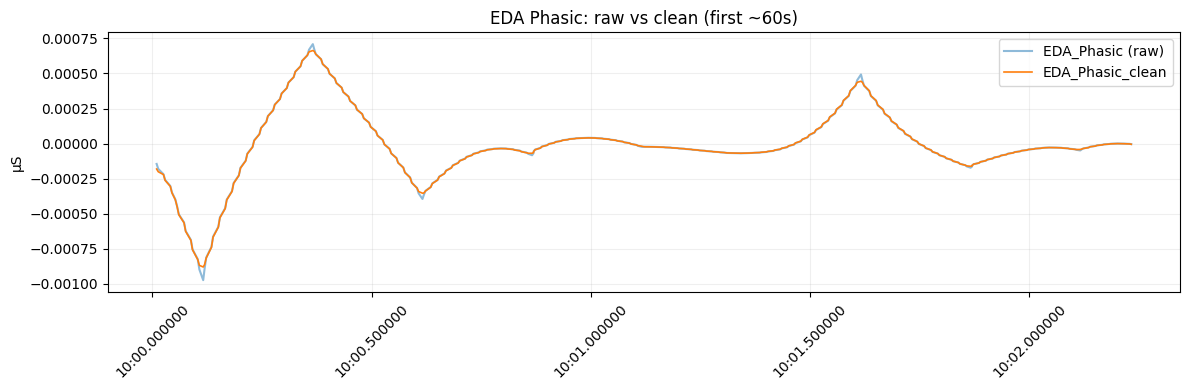

In [ ]:
# ===== Additional. 简单对比原始 phasic vs clean phasic（5Hz 上） =====

# 选前 60 秒左右的数据
n_show = min(len(df_ma), FS * 60)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df_ma["timestamp_local"].iloc[:n_show],
        df_ma["EDA_Phasic"].iloc[:n_show],
        label="EDA_Phasic (raw)", alpha=0.5)

ax.plot(df_ma["timestamp_local"].iloc[:n_show],
        df_ma["EDA_Phasic_clean"].iloc[:n_show],
        label="EDA_Phasic_clean", linewidth=1.2)

ax.set_title("EDA Phasic: raw vs clean (first ~60s)")
ax.set_ylabel("µS")
ax.grid(alpha=0.2)
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


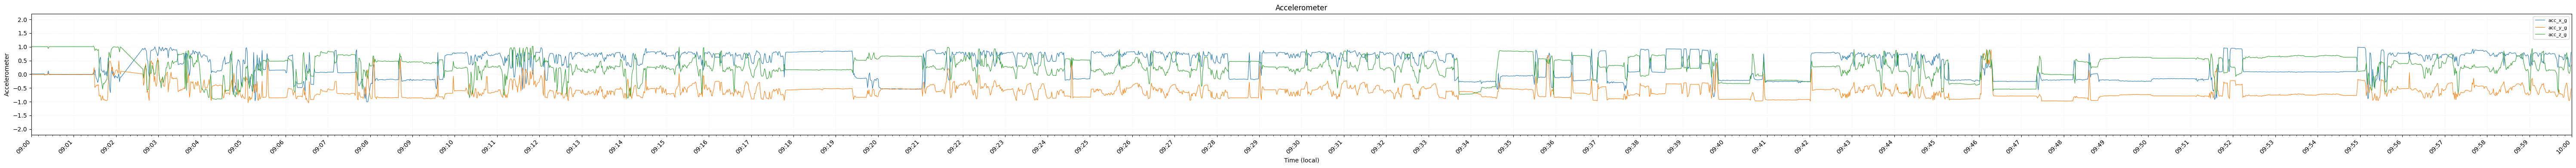

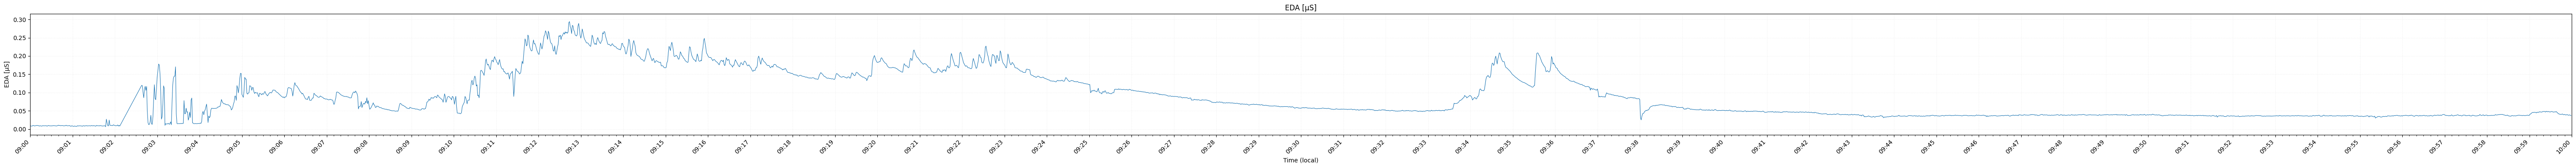

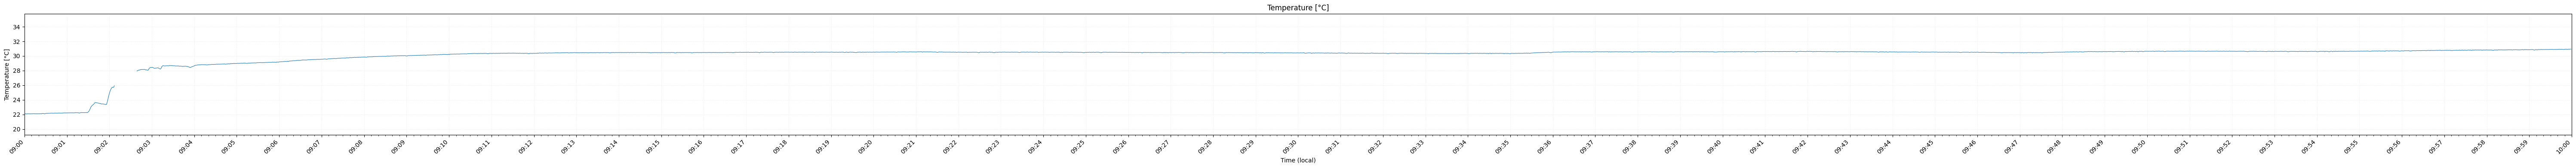

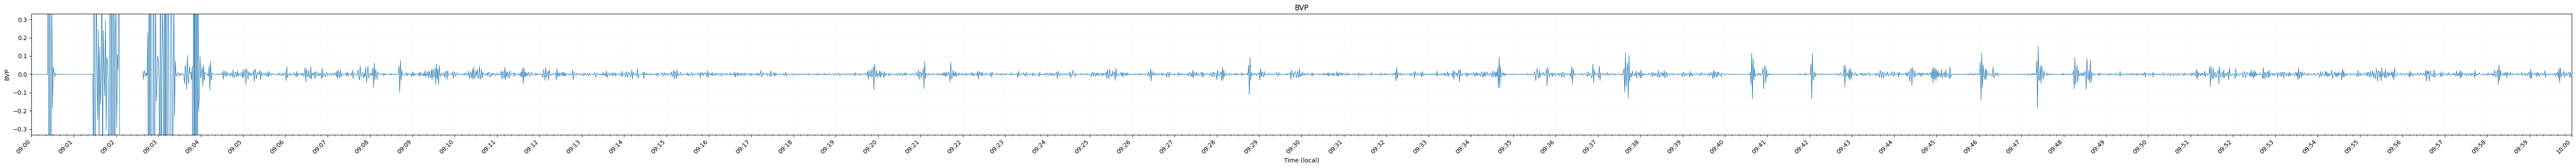

In [ ]:
# ====== 【OLD]】STEP 01: RAW DATA PLOT (ACC, EDA, TEMP, BVP) ======

signals = [
    ("Accelerometer", ["acc_x_g", "acc_y_g", "acc_z_g"]),
    ("EDA [µS]", ["eda_uS"]),
    ("Temperature [°C]", ["temperature_c"]),
    ("BVP", ["bvp"]),
]

fixed_ranges = {
    "Accelerometer": (-2.0, 2.0),
    "EDA [µS]": (0, 0.3),
    "Temperature [°C]": (20.0, 35.0),
    "BVP": (-0.3, 0.3),
}

# 时间格式
eastern = pytz.timezone("US/Eastern")
major_locator = mdates.MinuteLocator(interval=1)
major_formatter = mdates.DateFormatter("%H:%M", tz=eastern)
minor_locator = mdates.SecondLocator(bysecond=range(0, 60, 10))

# 动态宽度（按时长）
duration_seconds = max((end_time - start_time) / timedelta(seconds=1), 1)
width = duration_seconds * (1/60)  * 1

# === ⭐ 主循环：每个 signal 单独生成一个 figure ===
for title, cols in signals:
    fig, ax = plt.subplots(figsize=(width, 4))  # 每张图高度 4
    
    for col in cols:
        if col in df_downsampled:
            ax.plot(df_downsampled["timestamp_local"], df_downsampled[col], label=col, linewidth=0.8)

    # y 轴范围
    ymin, ymax = fixed_ranges[title]
    padding = 0.05 * (ymax - ymin if ymax != ymin else max(abs(ymax), 1))
    ax.set_ylim(ymin - padding, ymax + padding)

    # y 轴标签
    ax.set_ylabel(title)

    # 网格
    ax.grid(alpha=0.2, linestyle="--", linewidth=0.5)

    # legend（如果有多个数据列）
    if len(cols) > 1:
        ax.legend(fontsize=8)

    ax.tick_params(labelsize=10)

    # 时间轴格式
    ax.set_xlim(start_time, end_time)
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_major_formatter(major_formatter)
    ax.xaxis.set_minor_locator(minor_locator)

    # x 轴标签
    ax.set_xlabel("Time (local)")
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

    plt.title(title)
    plt.tight_layout()
    plt.show()


/Users/jianingyu/Downloads/MAS-S63_project/.venv/lib/python3.11/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/var/folders/22/0vpdqgyx5q717n66h48gjd500000gn/T/ipykernel_31422/3154870170.py:71: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .rolling("1S", center=True)
/var/folders/22/0vpdqgyx5q717n66h48gjd500000gn/T/ipykernel_31422/3154870170.py:78: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .rolling("1S", center=True)
/var/folders/22/0vpdqgyx5q717n66h48gjd500000gn/T/ipykernel_31422/3154870170.py:85: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .rolling("1S", center=True)
/var/folders/22/0vpdqgyx5q717n66h48gjd500000gn/T/ipykernel_31422/3154870170.py:93: FutureWarning: 'S' is deprecated and will be removed in a future version, please use

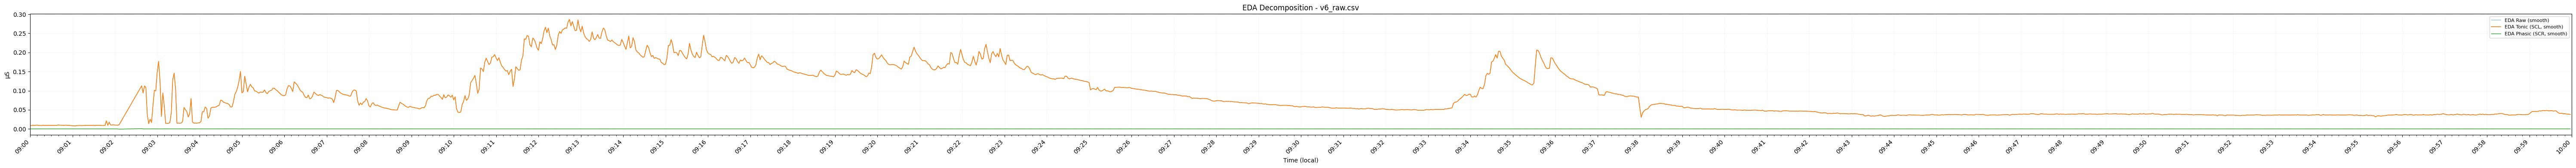

In [ ]:
# ====== 【OLD]】STEP 02: EDA PROCESSING WITH NEUROKIT2 ======
from scipy.signal import savgol_filter
# 基本设置
FS = 5  # 采样率（Hz）
EDA_COL = "eda_uS"       # EDA 列名
TIME_COL = "timestamp"   # 时间戳列名

sampling_rate = FS
eda_col = EDA_COL
time_col = TIME_COL

# 如果时间戳是字符串，解析为 datetime
if time_col in df.columns:
    df[time_col] = pd.to_datetime(df[time_col])

# 2. 取出 EDA 信号，并做插值补 NaN
if eda_col not in df.columns:
    raise ValueError(f"Column '{eda_col}' not found in file {CSV_PATH}")
eda_raw = df[eda_col].astype(float)
# 用线性插值补齐 NaN，避免 NeuroKit 出错
eda_interp = eda_raw.interpolate(limit_direction="both")

# 3. NeuroKit2 预处理 + SCL/SCR 分解
# signals 里会包含：
# 'EDA_Raw', 'EDA_Clean', 'EDA_Tonic', 'EDA_Phasic',
# 'SCR_Amplitude', 'SCR_RiseTime', 'SCR_RecoveryTime',
# 'SCR_Onsets', 'SCR_Peaks', ...
signals, info = nk.eda_process(eda_interp, sampling_rate=sampling_rate)

# 4. 合并回原始 df
processed = pd.concat([df.reset_index(drop=True), signals.reset_index(drop=True)], axis=1)

# 5. 计算一些简单的全局特征（方便之后对比不同 user）---------
scr_peaks_mask = processed["SCR_Peaks"] == 1

features = {
    "file": CSV_PATH.name,
    "n_samples": len(processed),
    "mean_scl": processed["EDA_Tonic"].mean(),
    "std_scl": processed["EDA_Tonic"].std(),
    "mean_phasic": processed["EDA_Phasic"].mean(),
    "scr_count": scr_peaks_mask.sum(),
    "scr_mean_amplitude": processed.loc[scr_peaks_mask, "SCR_Amplitude"].mean(),
}

# 6. 简单画一张全程的 clean + SCL + SCR (可以customize我们要visualize哪些数据)
if time_col in processed.columns:
    # 转为本地时区，并按选定窗口截取
    processed["timestamp_local"] = processed[time_col].dt.tz_convert("America/New_York")
    processed_win = (
        processed
        .set_index("timestamp_local")
        .sort_index()
        .loc[start_time:end_time]
        .reset_index()
    )

    
if not processed_win.empty:
    # 用 timestamp_local 做 index，后面才能用时间窗口滚动
    df_plot = (
        processed_win
        .set_index("timestamp_local")
        .sort_index()
    )

    # ===== 1）基于“秒”的平滑，而不是基于点数 =====
    # Tonic：30 秒滚动平均（趋势线非常平滑）
    df_plot["EDA_Tonic_smooth"] = (
        df_plot["EDA_Tonic"]
        .rolling("1S", center=True)
        .mean()
    )

    # Phasic：8 秒滚动平均（保留 SCR 形状）
    df_plot["EDA_Phasic_smooth"] = (
        df_plot["EDA_Phasic"]
        .rolling("1S", center=True)
        .mean()
    )

    # Raw：5 秒滚动平均，主要是去掉高频噪声
    df_plot["EDA_Raw_smooth"] = (
        df_plot["EDA_Raw"]
        .rolling("1S", center=True)
        .mean()
    )

    # ===== 2）为绘图再降采样一次（只影响图，不影响分析） =====
    # 可以试 "3S"、"5S"、"10S" 看效果，越大越平滑
    df_plot_resampled = (
        df_plot
        .resample("2S")  # ← 想再更平滑可以改成 "10S"
        .mean()
        .interpolate()
        .loc[start_time:end_time]
        .reset_index()
    )

    if df_plot_resampled.empty:
        print("No EDA data in selected window; adjust start_time/end_time.")
    else:
        x = df_plot_resampled["timestamp_local"]

        duration_seconds = max((end_time - start_time).total_seconds(), 1)
        width = duration_seconds * (1 / 60)

        fig, ax = plt.subplots(figsize=(width, 4))

        ax.plot(x, df_plot_resampled["EDA_Raw_smooth"],
                label="EDA Raw (smooth)", alpha=0.6, linewidth=0.8)
        ax.plot(x, df_plot_resampled["EDA_Tonic_smooth"],
                label="EDA Tonic (SCL, smooth)", linewidth=1.2)
        ax.plot(x, df_plot_resampled["EDA_Phasic_smooth"],
                label="EDA Phasic (SCR, smooth)", linewidth=1)

        ax.legend(fontsize=8)
        ax.set_xlim(start_time, end_time)
        ax.set_title(f"EDA Decomposition - {CSV_PATH.name}")
        ax.set_xlabel("Time (local)")
        ax.set_ylabel("μS")

        ax.grid(alpha=0.2, linestyle="--", linewidth=0.5)
        ax.tick_params(labelsize=10)

        eastern = pytz.timezone("US/Eastern")
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M", tz=eastern))
        ax.xaxis.set_minor_locator(mdates.SecondLocator(bysecond=range(0, 60, 10)))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

        plt.tight_layout()
        plt.show()


Local time span: 2025-11-17 09:02:52.404000-05:00 -> 2025-11-17 10:24:56.364000-05:00


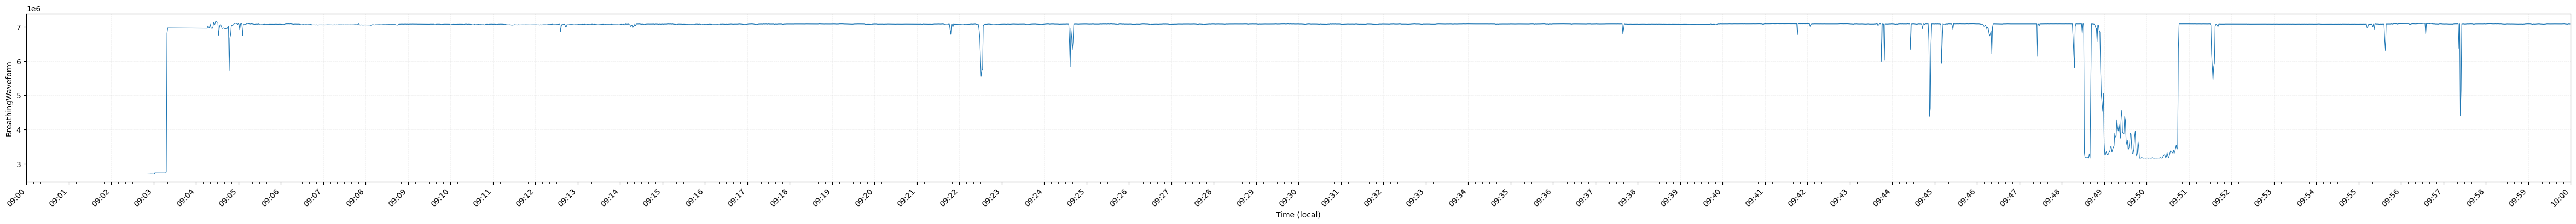

In [ ]:
breathing_csv_path = Path("visualizations/JINGFEI1117/Breathing.csv")
breathing_df = pd.read_csv(breathing_csv_path)

breathing_df["timestamp"] = pd.to_datetime(
    breathing_df["Time"],
    dayfirst=True,
    errors="coerce",
)

# 如果 CSV 时间是 UTC（设备可能用 UTC 记录），改为 True
ASSUME_TIME_IN_UTC = False
if ASSUME_TIME_IN_UTC:
    breathing_df["timestamp_local"] = (
        breathing_df["timestamp"]
        .dt.tz_localize("UTC")
        .dt.tz_convert("America/New_York")
    )
else:
    breathing_df["timestamp_local"] = breathing_df["timestamp"].dt.tz_localize(
        "America/New_York"
    )

print(
    "Local time span:",
    breathing_df["timestamp_local"].min(),
    "->",
    breathing_df["timestamp_local"].max(),
)

# 按本地时间选择窗口（修改这两个时间即可）
start_time = pd.Timestamp("2025-11-17 9:00:00", tz="America/New_York")
end_time   = pd.Timestamp("2025-11-17 10:00:00", tz="America/New_York")

breathing_slice = (
    breathing_df
    .set_index("timestamp_local")
    .sort_index()
    .loc[start_time:end_time]
    .reset_index()
)

if breathing_slice.empty:
    print("No data in selected time range; adjust start_time/end_time.")
else:
    # 200ms 下采样保证图像平滑且点数可控
    downsampled = (
        breathing_slice
        .set_index("timestamp_local")["BreathingWaveform"]
        .resample("1000ms")
        .mean()
        .reset_index()
    )

    duration_seconds = max((end_time - start_time) / pd.Timedelta(seconds=1), 1)
    width = duration_seconds * (1/60)  # 秒 -> 分钟，时间越长图越宽
    fig, ax = plt.subplots(figsize=(width, 4))
    ax.plot(
        downsampled["timestamp_local"],
        downsampled["BreathingWaveform"],
        linewidth=0.8,
    )

    eastern = pytz.timezone("US/Eastern")
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M", tz=eastern))
    ax.xaxis.set_minor_locator(mdates.SecondLocator(bysecond=range(0, 60, 10)))

    ax.set_xlim(start_time, end_time)
    ax.set_ylabel("BreathingWaveform")
    ax.set_xlabel("Time (local)")
    ax.grid(alpha=0.2, linestyle="--", linewidth=0.5)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
    plt.show()
